<a href="https://colab.research.google.com/github/nataliakartasheva/AMD_MBA/blob/master/AMD_MBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MARKET BASKET ANALYSIS

# 1.Introduction

## Kaggle connection

In [1]:
! pip install kaggle

In [2]:
# creating folders for kaggle api configuration file import
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

import os
if os.path.isfile('/content/drive/MyDrive/Kaggle/kaggle.json') == False:
  from google.colab import files
  print('Please upload your kaggle.json')
  uploaded = files.upload()

  os.mkdir('/content/drive/MyDrive/Kaggle/kaggle.json')

  import shutil
  shutil.move('/content/kaggle.json', '/content/drive/MyDrive/Kaggle/kaggle.json')

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle'

Mounted at /content/drive


In [3]:
# downloading datasets using kaggle api
!kaggle datasets download -d ashirwadsangwan/imdb-dataset 
!unzip imdb-dataset.zip

 99% 1.43G/1.44G [00:33<00:00, 25.8MB/s]
100% 1.44G/1.44G [00:33<00:00, 46.7MB/s]
Archive:  imdb-dataset.zip
  inflating: name.basics.tsv.gz      
  inflating: name.basics.tsv/name.basics.tsv  
  inflating: title.akas.tsv.gz       
  inflating: title.akas.tsv/title.akas.tsv  
  inflating: title.basics.tsv.gz     
  inflating: title.basics.tsv/title.basics.tsv  
  inflating: title.principals.tsv.gz  
  inflating: title.principals.tsv/title.principals.tsv  
  inflating: title.ratings.tsv.gz    
  inflating: title.ratings.tsv/title.ratings.tsv  


## Initialize PySpark session 

In [4]:
! pip install pyspark

     |████████████████████████████████| 281.4 MB 39 kB/s 
     |████████████████████████████████| 198 kB 80.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=e77c0abfbbe4e623f578944c0969b6069bef4d858522ee694346565cd532d28c
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [5]:
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, ArrayType, DoubleType
from pyspark.sql.functions import countDistinct, collect_set, udf, col, count, collect_set, lit, when, concat_ws, substring, length, col, expr, split, size

import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import time
from datetime import date, datetime

import pandas as pd
import numpy as np
from wordcloud import WordCloud

import itertools
from operator import add

import warnings
warnings.filterwarnings('ignore')

In [6]:
# initialize spark session
conf = SparkConf().setAppName("IMDB_MarketBasketAnalysis")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '32G')
        .set('spark.driver.memory', '128G')
        .set('spark.driver.maxResultSize', '24G'))

sc = SparkContext(conf= conf)
spark = SparkSession.builder.appName("IMDB_MarketBasketAnalysis").getOrCreate()

In [7]:
spark

In [8]:
#download datasets to local memmory
principals_path = '/content/title.principals.tsv.gz'
movies_path = '/content/title.basics.tsv.gz'
persons_path = '/content/name.basics.tsv.gz'

principals = spark.read.csv(principals_path, sep='\t', header=True, inferSchema=True)
movies = spark.read.csv(movies_path, sep= '\t', header=True, inferSchema=True)
persons = spark.read.csv(persons_path, sep='\t' , header=True, inferSchema=True)

#create a temp view
persons.createOrReplaceTempView('persons')
principals.createOrReplaceTempView('principals')
movies.createOrReplaceTempView('movies')

## Datasets

In [9]:
# view each table separately
print('principals')
principals.show(5)
print('movies')
movies.show(5)
print('persons')
persons.show(5)

principals
+---------+--------+---------+---------------+--------------------+-----------+
|   tconst|ordering|   nconst|       category|                 job| characters|
+---------+--------+---------+---------------+--------------------+-----------+
|tt0000001|       1|nm1588970|           self|                  \N|["Herself"]|
|tt0000001|       2|nm0005690|       director|                  \N|         \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|         \N|
|tt0000002|       1|nm0721526|       director|                  \N|         \N|
|tt0000002|       2|nm1335271|       composer|                  \N|         \N|
+---------+--------+---------+---------------+--------------------+-----------+
only showing top 5 rows

movies
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|       

## Data exploration

In [10]:
# checking if there are missings in important columns

print('movies_titleType',movies.filter(col('titleType').isNull()).count())
print('movies_primaryTitle:',movies.filter(col('primaryTitle').isNull()).count())

print('persons_primaryName:',persons.filter(col('primaryName').isNull()).count())
print('principals_category:',principals.filter(col('category').isNull()).count())


# no missings found - no need in extra proccessing of None's

movies_titleType 0
movies_primaryTitle: 0
persons_primaryName: 0
principals_category: 0


In [11]:
# checking the data types
print('principals')
principals.printSchema()
print('movies')
movies.printSchema()
print('persons')
persons.printSchema()

# correct data types

principals
root
 |-- tconst: string (nullable = true)
 |-- ordering: integer (nullable = true)
 |-- nconst: string (nullable = true)
 |-- category: string (nullable = true)
 |-- job: string (nullable = true)
 |-- characters: string (nullable = true)

movies
root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)

persons
root
 |-- nconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- birthYear: string (nullable = true)
 |-- deathYear: string (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- knownForTitles: string (nullable = true)



In [12]:
# construct a table: actor and all the movies he's played to
query_movies_and_actors = """SELECT movies.primaryTitle, persons.primaryName
                             FROM movies
                             INNER JOIN principals
                             ON principals.tconst = movies.tconst
                             INNER JOIN persons
                             ON persons.nconst = principals.nconst
                             WHERE (category = 'actor' or category = 'actress') and (movies.titleType = 'movie');
                             """
movies_and_actors = spark.sql(query_movies_and_actors)
movies_and_actors.createOrReplaceTempView('movies_and_actors')
movies_and_actors.show(5)

+--------------------+------------+
|        primaryTitle| primaryName|
+--------------------+------------+
|         Goin' South|John Belushi|
|National Lampoon'...|John Belushi|
|  Continental Divide|John Belushi|
|           Neighbors|John Belushi|
|                1941|John Belushi|
+--------------------+------------+
only showing top 5 rows



# 2.Finding insights

In [13]:
# statistics
print('rows in dataset:', movies_and_actors.count())
print('unique actors in the dataset:', movies_and_actors.select('primaryName').distinct().count())
print('unique movies in the dataset:', movies_and_actors.select('primaryTitle').distinct().count())

rows in dataset: 1693314
unique actors in the dataset: 560852
unique movies in the dataset: 346947


## Top 10 actors with the biggest number of movies

actors_with_top_n_of_movies
+----------------+--------+
|     primaryName|n_movies|
+----------------+--------+
|    Brahmanandam|     797|
|     Adoor Bhasi|     585|
|Matsunosuke Onoe|     565|
|    Eddie Garcia|     507|
|      Prem Nazir|     436|
|    Sung-il Shin|     411|
|    Paquito Diaz|     391|
|Masayoshi Nogami|     387|
|       Mammootty|     380|
|  Aachi Manorama|     356|
+----------------+--------+
only showing top 10 rows



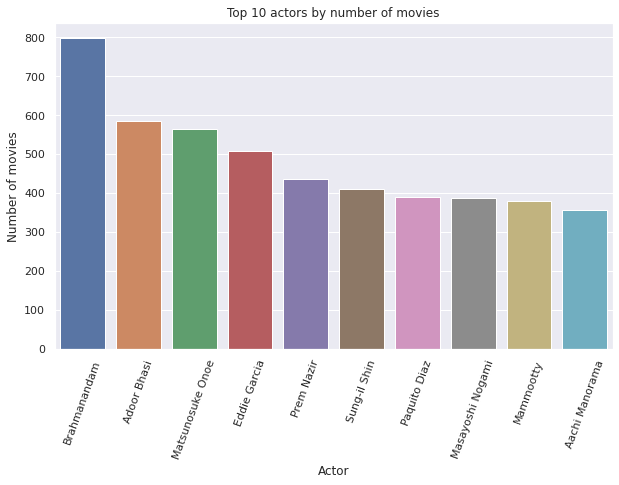

In [14]:
# 1. construct a table to see actors with the biggest number of movies
query_actors_with_top_n_of_movies = """SELECT primaryName, COUNT(*) AS n_movies
                                       FROM movies_and_actors
                                       GROUP BY primaryName
                                       ORDER BY n_movies desc
                                       """

actors_with_top_n_of_movies = spark.sql(query_actors_with_top_n_of_movies)
actors_with_top_n_of_movies.createOrReplaceTempView('actors_with_top_n_of_movies')
print('actors_with_top_n_of_movies')
actors_with_top_n_of_movies.show(10)

# plot actors with top 10 number of movies
top_10_actors = actors_with_top_n_of_movies.limit(10).cache()
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.barplot(x = "primaryName", y = "n_movies", data = top_10_actors.toPandas())
ax.set(title = "Top 10 actors by number of movies", xlabel = "Actor", ylabel = "Number of movies")
ax.set_xticklabels(ax.get_xticklabels(), rotation=70);

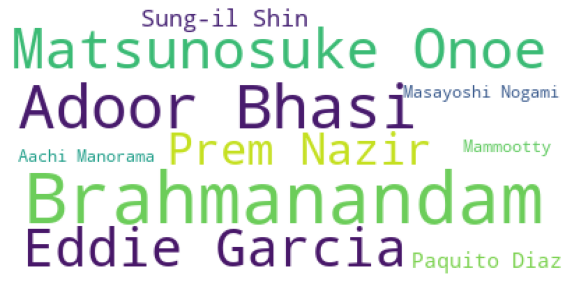

In [15]:
# 2. actors with top 10 number of movies as a worldcloud  
wordcloud_list_of_dicts = top_10_actors.select('primaryName', 'n_movies').rdd.map(lambda row: row.asDict()).collect()
wordcloud_dict = {dict_['primaryName'] : dict_['n_movies'] for dict_ in wordcloud_list_of_dicts}
wordcloud_object = WordCloud(background_color = "white").fit_words(wordcloud_dict)

# displaying the generated image
plt.figure(figsize = (10, 6))
plt.imshow(wordcloud_object)
plt.axis("off")
plt.show();

## Top 10 movies with the biggest number of actors

movies_with_top_n_of_actors
+------------+--------+
|primaryTitle|n_actors|
+------------+--------+
|      Hamlet|     145|
|     Macbeth|     141|
|   Honeymoon|     139|
|      Broken|     131|
|       Alone|     128|
|        Love|     127|
|      Desire|     125|
|      Mother|     123|
|  Homecoming|     117|
|The Stranger|     115|
+------------+--------+
only showing top 10 rows



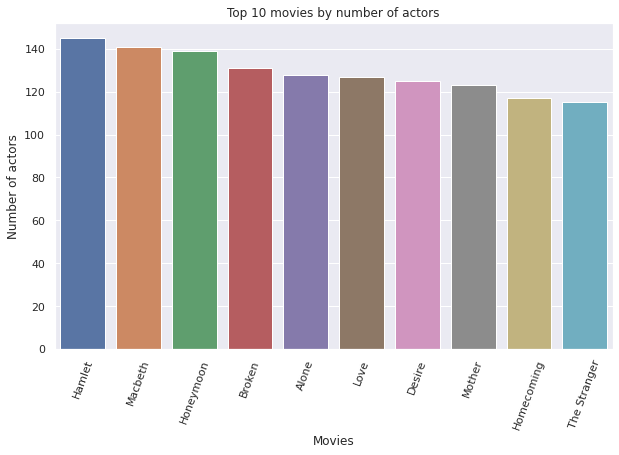

In [16]:
# 3. construct a table to see movies with the biggest number of actors
query_movies_with_top_n_of_actors = """SELECT primaryTitle, COUNT(*) AS n_actors
                                       FROM movies_and_actors
                                       GROUP BY primaryTitle
                                       ORDER BY n_actors desc
                                       """

movies_with_top_n_of_actors = spark.sql(query_movies_with_top_n_of_actors)
movies_with_top_n_of_actors.createOrReplaceTempView('movies_with_top_n_of_actors')
print('movies_with_top_n_of_actors')
movies_with_top_n_of_actors.show(10)

# plot movies with top 10 number of actors
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.barplot(x = "primaryTitle", y = "n_actors", data = movies_with_top_n_of_actors.limit(10).toPandas())
ax.set(title = "Top 10 movies by number of actors", xlabel = "Movies", ylabel = "Number of actors")
ax.set_xticklabels(ax.get_xticklabels(), rotation=70);

# 3.Apriori Algorithm

## Data organisation

In [17]:
# making a dataframe of movies and actors:  'movie' : ['actor_1', 'actor_2', 'actor_3']
baskets_unqiue_items_df = movies_and_actors.groupBy('primaryTitle').agg(collect_set('primaryName').alias('items'))

# making a list of actors per each movie: [['actor_1', 'actor_2', 'actor_3'],['actor_1', 'actor_2', 'actor_3']]    
list_of_items_per_each_basket = list(baskets_unqiue_items_df.select('items').toPandas()['items'])

# making a tuple of actors per each movie: [('actor_1', 'actor_2', 'actor_3'),('actor_1', 'actor_2', 'actor_3')] 
tuple_of_items_per_each_basket = [tuple(i) for i in list_of_items_per_each_basket]

toPandas is the most efficient way to make transformation to list here <br>
<a href="https://mungingdata.com/pyspark/column-to-list-collect-tolocaliterator/">Reference</a>

In [18]:
!pip install efficient_apriori
from efficient_apriori import apriori

## Algorithm implementation

<b>Hyperparameters of the algorithm:</b>
 <li>input_data - our data organized on previous steps</li>
 <li>min_support - the threshold that shows minimum allowed frequency of an itemset</li>
 <li>min_confidence - allows to delete rules with low confidence</li>

In [19]:
# we choose at least 100 joint occurences
min_support = 100/len(tuple_of_items_per_each_basket) #has to be expressed as a percentage for efficient-apriori

# we now set min_confidence = 0 to obtain all the rules
min_confidence = 0

# apply apriori algorithm
itemsets, rules = apriori(tuple_of_items_per_each_basket, min_support=min_support, min_confidence=min_confidence)

# 4.Conclusion

### Frequent pairs

In [20]:
# create pandas dataframe with the result(pairs)
actors_pair = np.array([(key,value) for key, value in itemsets[2].items()]).reshape(-1,2)

rules_pair = list(filter(lambda rule: len(rule.lhs) == 1 and len(rule.rhs) == 1, rules))
conf_pair = np.array([round(rule.confidence,2) for rule in rules_pair]).reshape(-1,2)
lift_pair = np.array([round(rule.lift,2) for rule in rules_pair]).reshape(-1,2)

result_pair_data = np.concatenate((actors_pair, conf_pair, lift_pair), axis=1)

columns_main = ['actors','joint_appearences']
columns_conf = [f'conf_{i}' for i in range(1, conf_pair.shape[1]+1)]
columns_lift = [f'lift_{i}' for i in range(1, lift_pair.shape[1]+1)]
columns_pair = columns_main + columns_conf + columns_lift

result_pair_df = pd.DataFrame(result_pair_data, columns = columns_pair)
result_pair_df= result_pair_df.sort_values('joint_appearences', ascending = False).reset_index(drop = True)

In [21]:
result_pair_df

,actors,joint_appearences,conf_1,conf_2,lift_1,lift_2
0,"(Adoor Bhasi, Prem Nazir)",236,0.54,0.4,321.02,321.02
1,"(Adoor Bhasi, Bahadur)",169,0.49,0.29,288.01,288.01
2,"(Adoor Bhasi, Jayabharati)",162,0.53,0.28,317.09,317.09
3,"(Kijaku Ôtani, Matsunosuke Onoe)",146,0.29,0.91,623.21,623.21
4,"(Kitsuraku Arashi, Matsunosuke Onoe)",126,0.25,0.98,672.3,672.3
5,"(Adoor Bhasi, Thikkurisi Sukumaran Nair)",123,0.47,0.21,280.57,280.57
6,"(Kijaku Ôtani, Kitsuraku Arashi)",113,0.88,0.71,1914.31,1914.31
7,"(Matsunosuke Onoe, Suminojo Ichikawa)",113,0.97,0.22,659.62,659.62
8,"(Bahadur, Jayabharati)",109,0.36,0.31,358.65,358.65
9,"(Dolphy, Panchito)",102,0.48,0.43,704,704


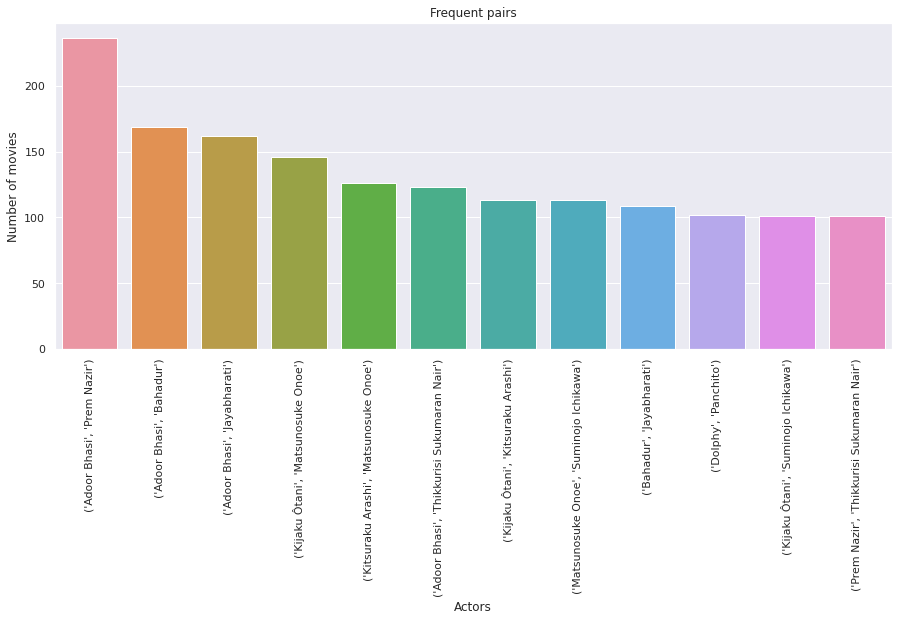

In [22]:
# plot frequent pairs
sns.set(rc={'figure.figsize':(15,6)})
ax = sns.barplot(x = "actors", y = "joint_appearences", data = result_pair_df)
ax.set(title = "Frequent pairs", xlabel = "Actors", ylabel = "Number of movies")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

### Frequent triples

In [23]:
# create pandas dataframe with the result(triples)
actors_triple = np.array([(key,value) for key, value in itemsets[3].items()]).reshape(-1,2)

rules_triple = list(filter(lambda rule: (len(rule.lhs) == 2 and len(rule.rhs) == 1) or (len(rule.lhs) == 1 and len(rule.rhs) == 2) , rules))
conf_triple = np.array([round(rule.confidence,2) for rule in rules_triple]).reshape(-2,6)
lift_triple = np.array([round(rule.lift,2) for rule in rules_triple]).reshape(-2,6)

result_triple_data = np.concatenate((actors_triple, conf_triple, lift_triple), axis=1)

columns_main = ['actors','joint_appearences']
columns_conf = [f'conf_{i}' for i in range(1, conf_triple.shape[1]+1)]
columns_lift = [f'lift_{i}' for i in range(1, lift_triple.shape[1]+1)]
columns_triple = columns_main + columns_conf + columns_lift

result_triple_df = pd.DataFrame(result_triple_data, columns = columns_triple)
result_triple_df= result_triple_df.sort_values('joint_appearences', ascending = False).reset_index(drop = True)

In [24]:
result_triple_df

,actors,joint_appearences,conf_1,conf_2,conf_3,conf_4,conf_5,conf_6,lift_1,lift_2,lift_3,lift_4,lift_5,lift_6
0,"(Kijaku Ôtani, Kitsuraku Arashi, Matsunosuke O...",112,0.89,0.77,0.99,0.22,0.88,0.7,1927.48,2079.31,676.92,676.92,2079.31,1927.48
1,"(Kijaku Ôtani, Matsunosuke Onoe, Suminojo Ichi...",100,0.88,0.99,0.68,0.85,0.2,0.62,1918.95,676.2,2031.07,2031.07,676.2,1918.95


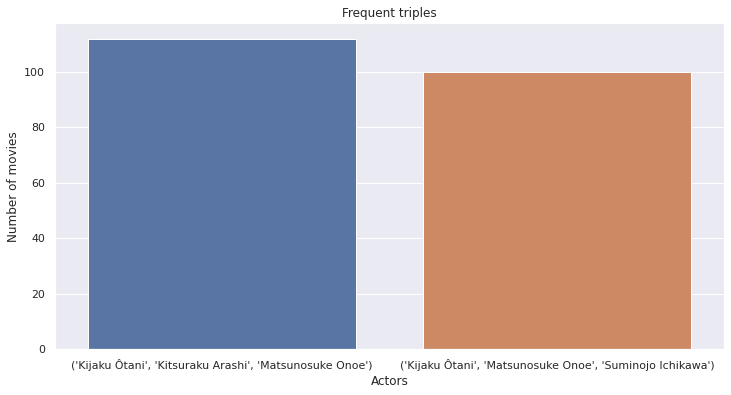

In [25]:
# plot frequent triples
sns.set(rc={'figure.figsize':(12,6)})
ax = sns.barplot(x = "actors", y = "joint_appearences", data = result_triple_df)
ax.set(title = "Frequent triples", xlabel = "Actors", ylabel = "Number of movies")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);